# Tutorial: Hand gesture classification with EMG data using Riemannian metrics

In this notebook we are using EMG time series collected by 8 electrodes placed on the arm skin. We are going to show how to 
- Process these kind of signal into covariance matrices that we can manipulate with geomstats tools.
- How to apply ML algorithms on this data to classify four different hand gestures present in the data (Rock, Paper, Scissors, Ok).
- How do the different methods (using Riemanian metrics, projecting on tangent space, Euclidean metric) compare to each other.

<img src="figures/paper_rock_scissors.png" />

# Context

The data are acquired from somOS-interface: an sEMG armband that allows you to interact via bluetooth with an Android smartphone (you can contact Marius Guerard (marius.guerard@gmail.com) or Renaud Renault (renaud.armand.renault@gmail.com) for more info on how to make this kind of armband yourself). 

An example of application is to record static signs that are linked with different actions (moving a cursor and clicking, sign recognition for command based personal assistants, ...). In these experiments, we want to evaluate the difference in performance (measured as the accuracy of sign recognition) between three different real life situations where we change the conditions of training (when user record signs or "calibrate" the device) and testing (when the app guess what sign the user is doing):

- 1. What is the accuracy when doing sign recognition right after training?
- 2. What is the accuracy when calibrating, removing and replacing the armband at the same position and then testing? 
- 3. What is the accuracy when calibrating, removing the armband and giving it to someone else that is testing it without calibration?

To simulate these situations, we record data from two different users (rr and mg) and in two different sessions (s1 or s2). The user put the bracelet before every session and remove it after every session.

Quick description of the data:
- Each row corresponds to one acquisition, there is an acquisition every ~4 ms for 8 electrodes which correspond to a 250Hz acquisition rate.
- The time column is in ms.
- The columns c0 to c7 correspond to the electrical value recorded at each of the 8 electrodes (arbitrary unit).
- The label correspond to the sign being recorded by the user at this time point ('rest', 'rock', 'paper', 'scissors', or 'ok). 'rest' correspond to a rested arm.
- the exp identify the user (rr and mg) and the session (s1 or s2)

Note: Another interesting use case, not explored in this notebook, would be to test what is the accruacy when calibrating, removing the armband and giving it to someone else that is calibrating it on its own arm before testing it. The idea being that transfer learning might help getting better results (or faster calibration) than calibrating on one user.

# Setup

Before starting this tutorial, we set the working directory to be the root of the geomstats repository. In order to have the code working on your machine, you need to change this path to the path of your geomstats repository.

In [1]:
import os
import subprocess
import matplotlib
matplotlib.interactive(True)
import matplotlib.pyplot as plt

geomstats_gitroot_path = subprocess.check_output(
    ['git', 'rev-parse', '--show-toplevel'], 
    universal_newlines=True)

os.chdir(geomstats_gitroot_path[:-1])

print('Working directory: ', os.getcwd())

import geomstats.backend as gs

gs.random.seed(2021)

Working directory:  /home/marius/proj/geomstats


INFO: Using numpy backend


# Parameters

In [2]:
N_ELECTRODES = 8

# The Data


In [3]:
import geomstats.datasets.utils as data_utils

data = data_utils.load_emg()

In [4]:
data.head()

time   c0   c1   c2   c3   c4   c5   c6   c7 label    exp
0    23  127  123  128  134  125  128  130  124  rest  mg_s1
1    28  126  130  128  119  129  128  126  133  rest  mg_s1
2    32  129  130  127  125  129  129  127  130  rest  mg_s1
3    36  127  128  126  123  128  127  125  131  rest  mg_s1
4    40  127  128  129  124  127  129  127  128  rest  mg_s1

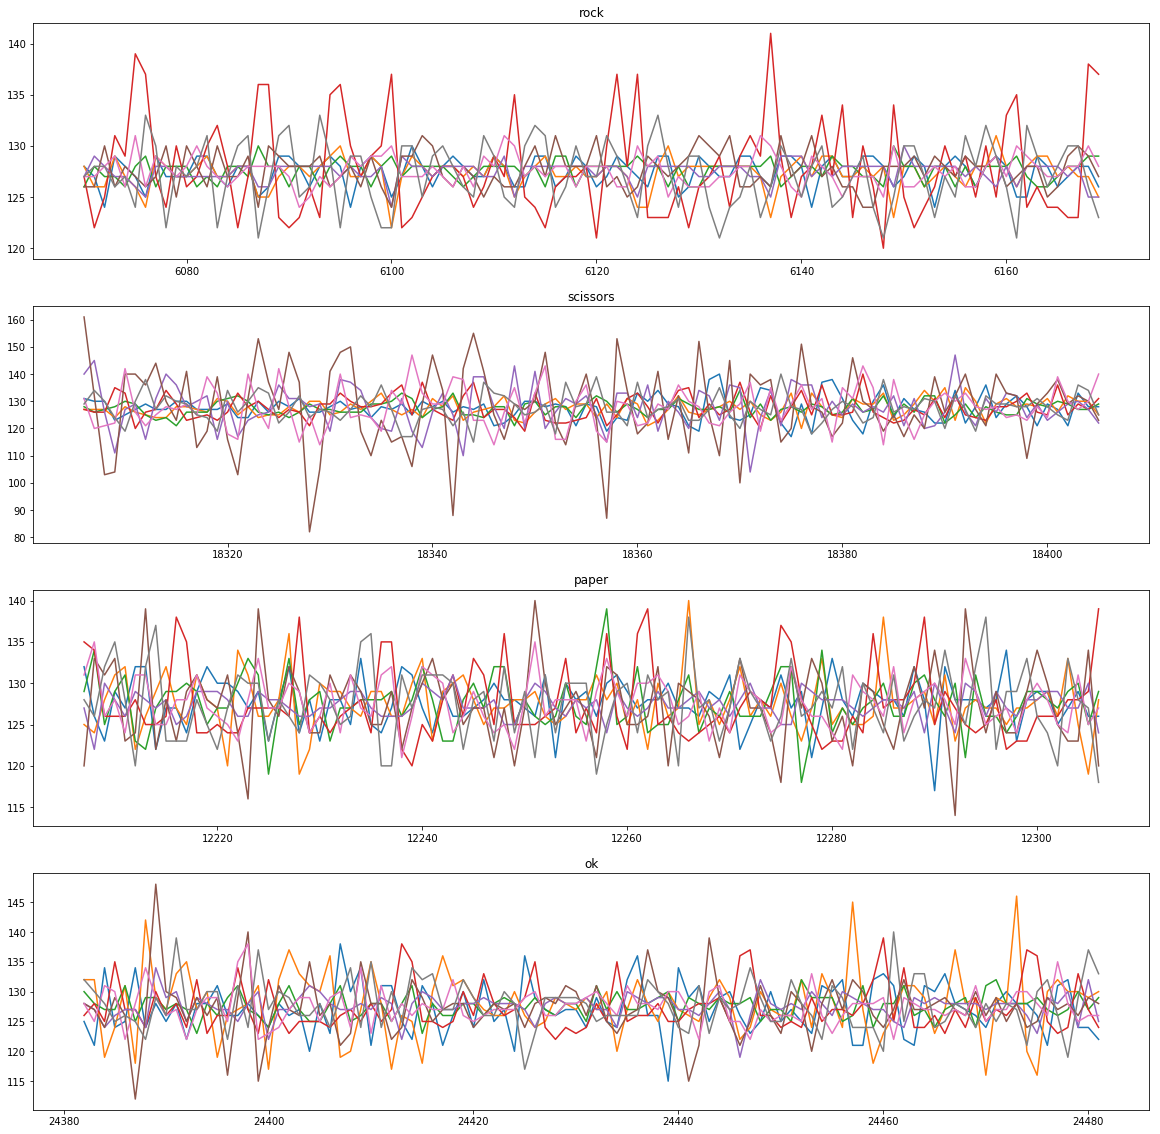

In [5]:
fig, ax = plt.subplots(4, figsize=(20, 20))
label_list = ['rock', 'scissors', 'paper', 'ok']
for i, label_i in enumerate(label_list):
    sign_df = data[data.label==label_i].iloc[:100]
    for electrode in range(N_ELECTRODES):
        ax[i].plot(sign_df.iloc[:, 1 + electrode])
        ax[i].title.set_text(label_i)

We are removing the sign 'rest' for the rest of the analysis.

In [6]:
data = data[data.label != 'rest']

## Preprocessing into covariance matrices

In [7]:
import numpy as np
import pandas as pd

### Parameters.
N_STEPS = 100
LABEL_MAP = {'rock': 0, 'scissors': 1, 'paper': 2, 'ok': 3}
MARGIN = 1000

Unpacking data into arrays for batching

In [8]:
data_dict = {
    'time_vec': gs.array(data.time),
    'raw_data': gs.array(data[['c{}'.format(i) for i in range(N_ELECTRODES)]]),
    'label': gs.array(data.label),
    'exp': gs.array(data.exp)}

In [9]:
from geomstats.datasets.prepare_emg_data import TimeSeriesCovariance

cov_data = TimeSeriesCovariance(data_dict, N_STEPS, N_ELECTRODES, LABEL_MAP, MARGIN)
cov_data.transform()

We check that these matrics belong to the space of SPD matrices.

In [10]:
import geomstats.geometry.spd_matrices as spd

manifold = spd.SPDMatrices(N_ELECTRODES)

In [11]:
gs.all(manifold.belongs(cov_data.covs))

True

### Covariances plot of the euclidean average

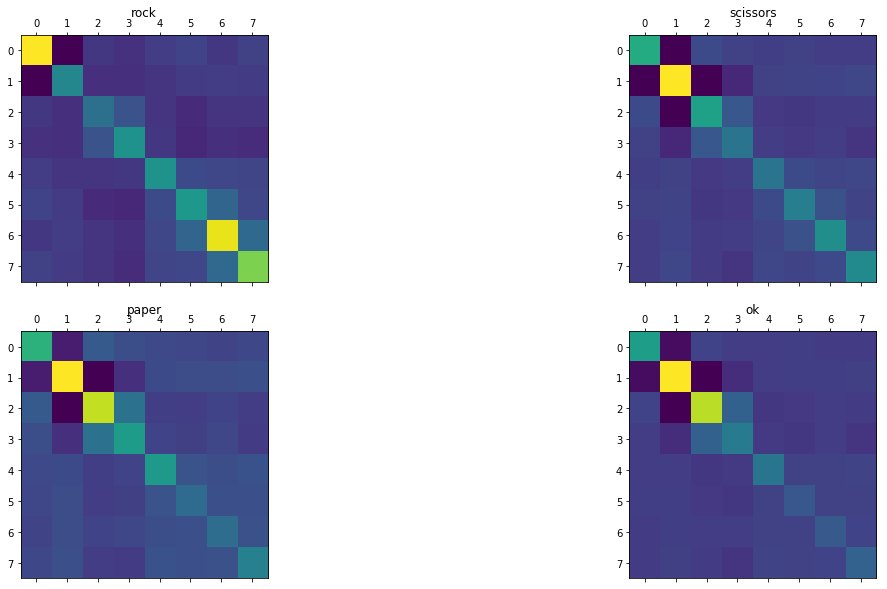

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
for label_i, i in cov_data.label_map.items():
    label_ids = np.where(cov_data.labels==i)[0]
    sign_cov_mat = cov_data.covs[label_ids]
    mean_cov = np.mean(sign_cov_mat, axis=0)
    ax[i // 2, i % 2].matshow(mean_cov)
    ax[i // 2, i % 2].title.set_text(label_i)

Looking at the euclidean average of the spd matrices for each sign, does not show a striking difference between 3 of our signs (scissors, paper, and ok). Minimum Distance to Mean (MDM) algorithm will probably performed poorly if using euclidean mean here.

### Covariances plot of the Frechet Mean of the affine invariant metric

In [13]:
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.geometry.spd_matrices import SPDMetricAffine

In [14]:
metric_affine = SPDMetricAffine(N_ELECTRODES)
mean_affine = FrechetMean(metric=metric_affine, point_type='matrix')

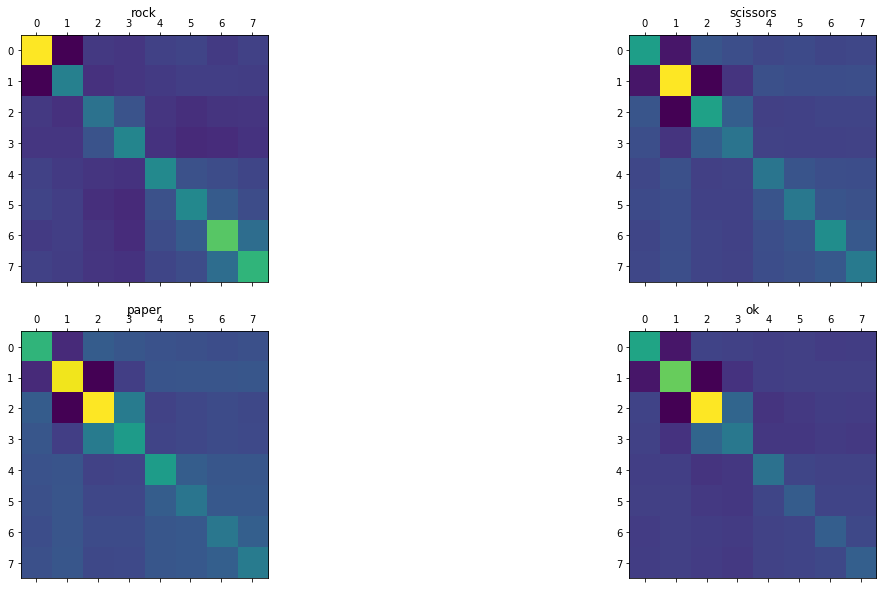

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
for label_i, i in cov_data.label_map.items():
    label_ids = np.where(cov_data.labels==i)[0]
    sign_cov_mat = cov_data.covs[label_ids]
    mean_affine.fit(X=sign_cov_mat)
    mean_cov = mean_affine.estimate_
    ax[i // 2, i % 2].matshow(mean_cov)
    ax[i // 2, i % 2].title.set_text(label_i)

We see that the average matrices computed using the affine invariant metric are now more differenciated from each other and can potentially give better results, when using MDM to predict the sign linked to a matrix sample.

# Sign Classification